In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data as data_torch
import random
from tqdm import tnrange, tqdm_notebook

C:\Users\aescobar13\AppData\Local\Continuum\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


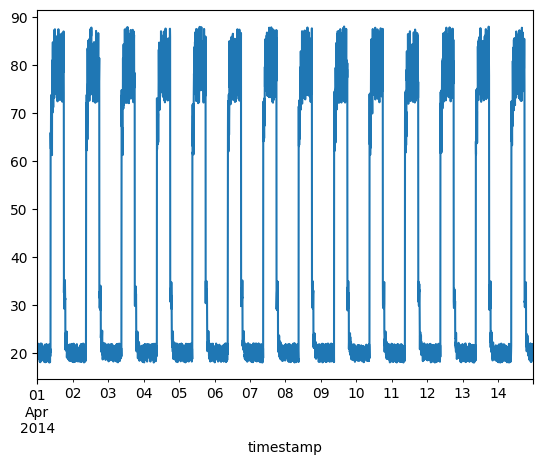

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

In [69]:
np.concatenate(x_train, axis=0).shape, df_small_noise.shape, x_train.shape

((1078560, 1), (4032, 1), (3745, 288, 1))

In [73]:
def create_ts_from_seq(sequence):
    results = np.zeros(sequence.shape[0])
    time_step = sequence.shape[1]
    for k, seq_i in enumerate(range(0,sequence.shape[0],time_step )):
        try:
            results[seq_i:seq_i+time_step]=sequence[k,:,0]
        except: 
            pass
    return results

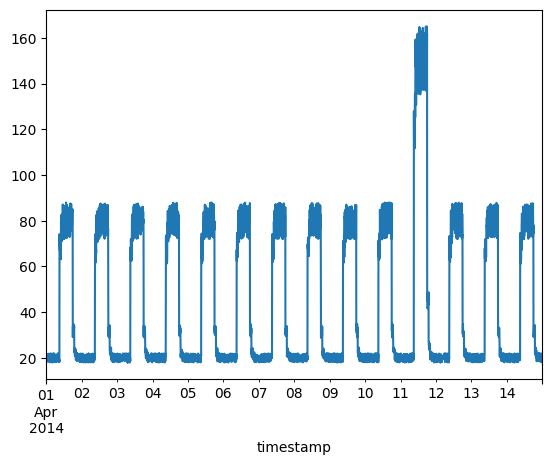

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [7]:
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [67]:
len(df_training_value.values)-288+1

3745

In [78]:
index_data = list(range(x_train.shape[0]))
train_index = random.sample(index_data, int(len(index_data)*0.8))
val_test_index = list(set(index_data)-set(train_index))
val_index = random.sample(val_test_index, int(len(val_test_index)*0.5))
test_index = list(set(val_test_index)-set(val_index))
# Creando las particiones
data_dic = {'train':x_train[train_index],\
           'val':x_train[val_index],\
           'test':x_train[test_index]}

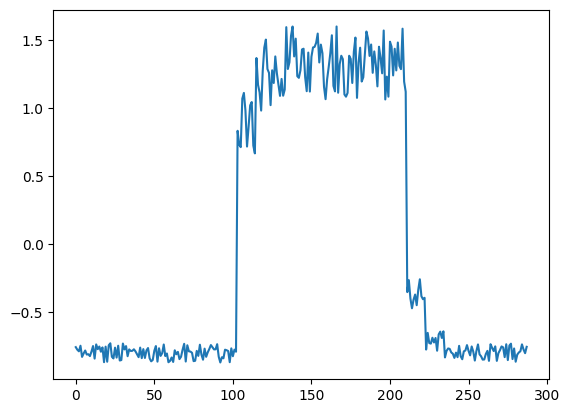

In [79]:
plt.plot(x_train[5])

In [80]:
class TS_dataLoader(data_torch.Dataset):
    def __init__(self, list_TS):

        self.list_TS = list_TS
        
        
    def __getitem__(self, index):
        TS_i = self.list_TS[index]
        return TS_i
        

    def __len__(self):
        return len(self.list_TS)

In [81]:
partitions = ['train', 'val', 'test']
batch_size = 128
shuffle = False
lr = 0.001
TS_datasets = {x: TS_dataLoader(data_dic[x]) for x in partitions}
dataloaders = {x: torch.utils.data.DataLoader(TS_datasets[x], batch_size=batch_size,\
                                              shuffle=shuffle) for x in partitions}
dataset_sizes = {x: len(TS_datasets[x]) for x in partitions}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'train': 2996, 'val': 374, 'test': 375}

In [13]:
class AutoEncoder_TS(nn.Module):
    def __init__(self):
        super(AutoEncoder_TS, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=6,stride=2,padding=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(in_channels=32,out_channels=16,kernel_size=6,stride=2,padding=3)
        self.convTrans = nn.ConvTranspose1d(in_channels=16, out_channels=16,kernel_size=6,stride=2,padding=3)
        self.convTrans2 = nn.ConvTranspose1d(in_channels=16, out_channels=32,kernel_size=6,stride=2,padding=2)
        self.convTrans3 = nn.ConvTranspose1d(in_channels=32, out_channels=1,kernel_size=5,stride=1, padding=2)
    def forward(self, x):
        
        x = self.dropout(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.dropout(self.relu(self.convTrans(x)))
        x = self.relu(self.convTrans2(x))
        x = self.convTrans3(x)
        return x

In [14]:
model = AutoEncoder_TS()
model

AutoEncoder_TS(
  (conv1): Conv1d(1, 32, kernel_size=(6,), stride=(2,), padding=(3,))
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (conv2): Conv1d(32, 16, kernel_size=(6,), stride=(2,), padding=(3,))
  (convTrans): ConvTranspose1d(16, 16, kernel_size=(6,), stride=(2,), padding=(3,))
  (convTrans2): ConvTranspose1d(16, 32, kernel_size=(6,), stride=(2,), padding=(2,))
  (convTrans3): ConvTranspose1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,))
)

In [15]:
from torchsummary import summary
summary(model, (1,288))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 145]             224
              ReLU-2              [-1, 32, 145]               0
           Dropout-3              [-1, 32, 145]               0
            Conv1d-4               [-1, 16, 73]           3,088
              ReLU-5               [-1, 16, 73]               0
   ConvTranspose1d-6              [-1, 16, 144]           1,552
              ReLU-7              [-1, 16, 144]               0
           Dropout-8              [-1, 16, 144]               0
   ConvTranspose1d-9              [-1, 32, 288]           3,104
             ReLU-10              [-1, 32, 288]               0
  ConvTranspose1d-11               [-1, 1, 288]             161
Total params: 8,129
Trainable params: 8,129
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion_loss = torch.nn.MSELoss(reduction='sum')

In [17]:
for epoch in range(0, 100 ):

    iter_current = 0
    loss_epoch = 0
    for phase in partitions[0:2]:           
        if phase == partitions[0]:
            model.train()
        else:
            model.eval() 
        running_loss = 0.0

        for k, batch_data in enumerate(dataloaders[phase]):
            ts_patch  = batch_data
            ts_patch = ts_patch.float()
            ts_patch = ts_patch.permute((0,2,1))
            

#             ts_patches = patches.to(device)
#             labels_breakout = labels_breakout.unsqueeze(1)
#             labels_breakout = labels_breakout.to(device)
            optimizer.zero_grad()
            #===================
            # Forward
            #=====================
            output_ts = model(ts_patch)

            #=====================
            # Compute loss
            #=====================
            loss = criterion_loss(output_ts.float(), ts_patch.float())
#             loss = loss.to(device)
            #===================
            # backward
            #=====================
            if phase == partitions[0]:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

            iter_current += 1

        loss_epoch =  running_loss / float(dataset_sizes[phase])

        if iter_current%100 == 0:
            print('iter-%s'%iter_current)

        print("%s || epoch-%s: lossB = %.5f"%(phase, epoch, loss_epoch))

train || epoch-0: lossB = 196.30240
val || epoch-0: lossB = 35.41964
train || epoch-1: lossB = 24.27152
val || epoch-1: lossB = 12.07282
train || epoch-2: lossB = 14.85667
val || epoch-2: lossB = 9.42500
train || epoch-3: lossB = 12.45670
val || epoch-3: lossB = 8.40041
train || epoch-4: lossB = 10.59597
val || epoch-4: lossB = 7.40048
train || epoch-5: lossB = 9.08760
val || epoch-5: lossB = 6.56951
train || epoch-6: lossB = 7.90305
val || epoch-6: lossB = 6.00574
train || epoch-7: lossB = 7.09039
val || epoch-7: lossB = 5.93423
train || epoch-8: lossB = 6.55369
val || epoch-8: lossB = 5.65752
train || epoch-9: lossB = 6.04789
val || epoch-9: lossB = 5.35414
train || epoch-10: lossB = 5.61647
val || epoch-10: lossB = 5.18005
train || epoch-11: lossB = 5.26796
val || epoch-11: lossB = 5.12222
train || epoch-12: lossB = 4.93142
val || epoch-12: lossB = 4.74475
train || epoch-13: lossB = 4.66686
val || epoch-13: lossB = 4.89655
train || epoch-14: lossB = 4.41366
val || epoch-14: lossB = 

In [82]:
partitions = ['test']
batch_size = 1
shuffle = False
lr = 0.001
TS_datasets = {x: TS_dataLoader(data_dic[x]) for x in partitions}
dataloaders = {x: torch.utils.data.DataLoader(TS_datasets[x], batch_size=batch_size,\
                                              shuffle=shuffle) for x in partitions}
dataset_sizes = {x: len(TS_datasets[x]) for x in partitions}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'test': 375}

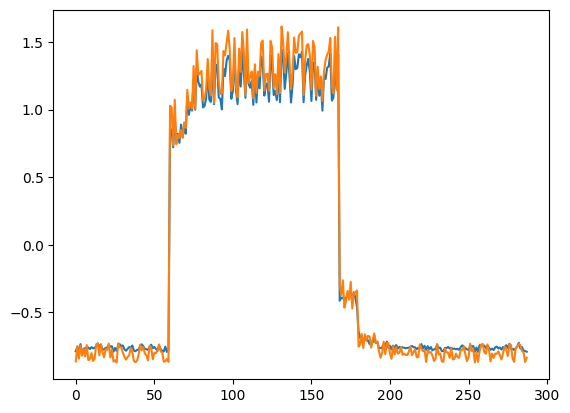

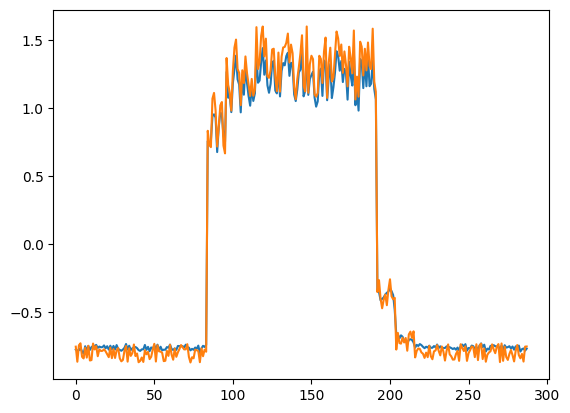

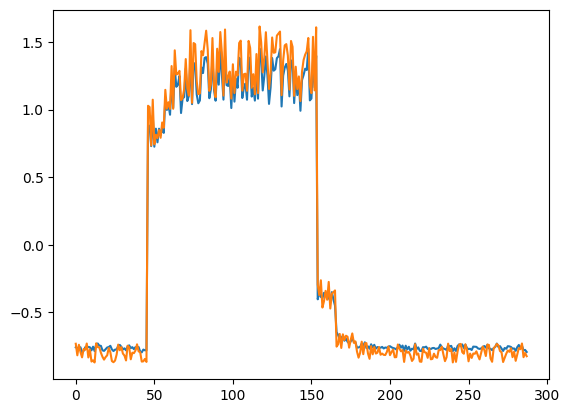

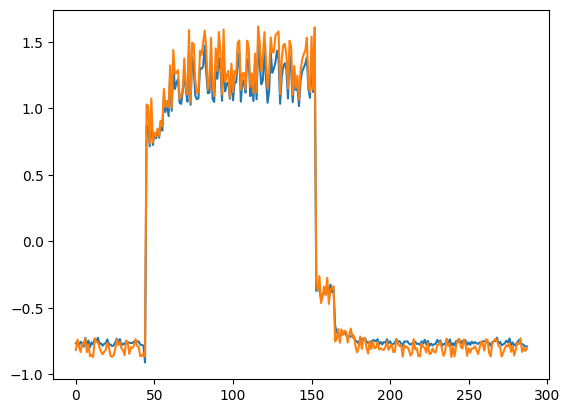

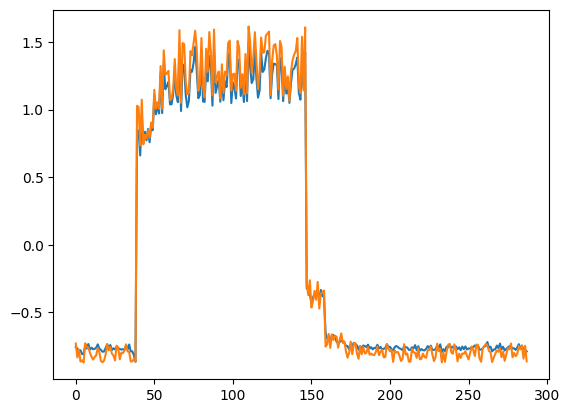

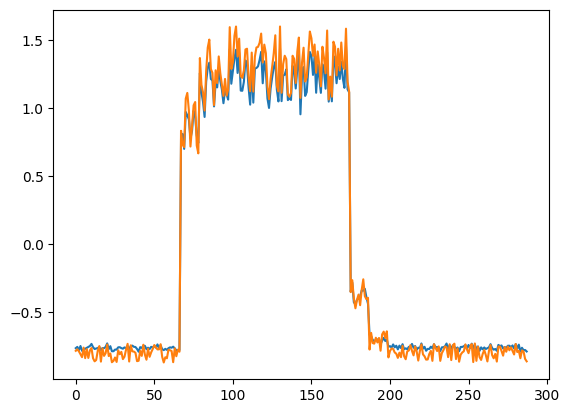

In [84]:
# torch.save(model.state_dict(), r'C:\Users\aescobar13\OneDrive - Schlumberger\AI Academy\Especializacion python\Taller_TS\results\model_Autoencoder_TS.ckpt')
model.eval()
loss_prediction = []
predictions_test = []
ts_real = []
for k, batch_data in enumerate(dataloaders['test']):
    ts_patch  = batch_data
    ts_patch = ts_patch.float()
    ts_patch = ts_patch.permute((0,2,1))
    output_ts = model(ts_patch)
#     print(output_ts.shape)
    predictions_test.append(output_ts[0].squeeze().detach().numpy())
    ts_real.append(ts_patch[0].squeeze().detach().numpy())
    if k<=5:
        plt.plot(output_ts[0].squeeze().detach().numpy())
        plt.plot(ts_patch[0].squeeze().detach().numpy())
        plt.show()
    loss_prediction.append(np.mean(np.abs(output_ts.detach().numpy() - ts_patch.numpy()), axis=1))
#     break
# create_ts_from_seq(sequence)    

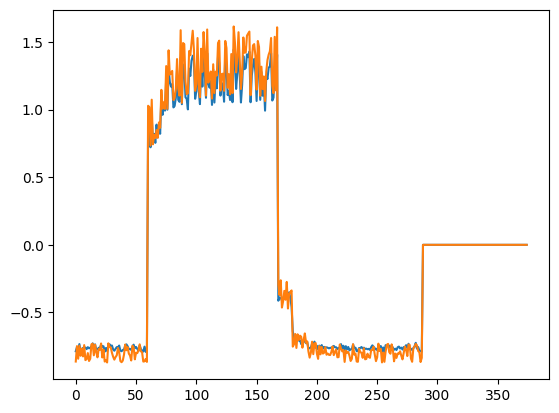

In [89]:
plt.plot(create_ts_from_seq(np.expand_dims(np.array(predictions_test),axis=2)))
plt.plot(create_ts_from_seq(np.expand_dims(np.array(ts_real),axis=2)))
plt.show()
# np.array(predictions_test).shape

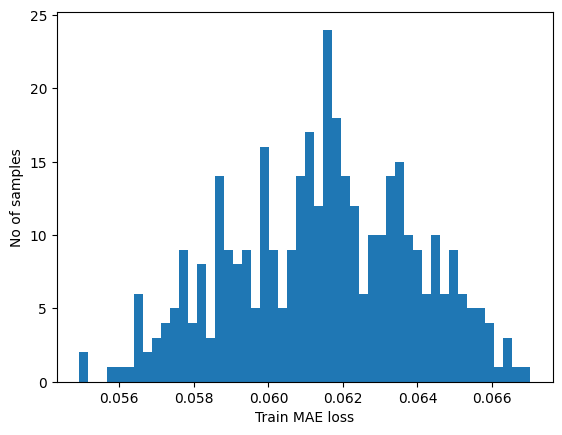

Reconstruction error threshold:  0.5582012


In [45]:
# train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(np.array(loss_prediction).mean(axis=2), bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(loss_prediction)
print("Reconstruction error threshold: ", threshold)

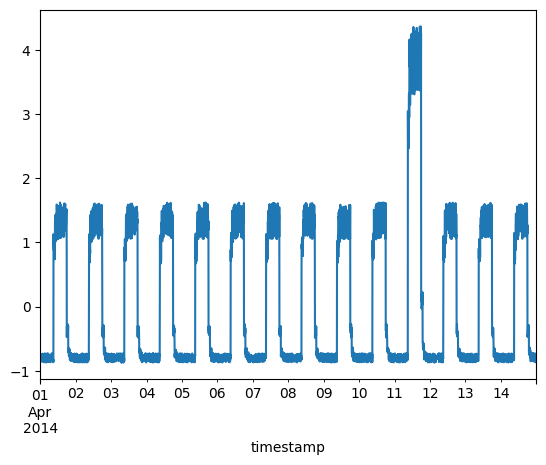

Test input shape:  (3745, 288, 1)


In [90]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

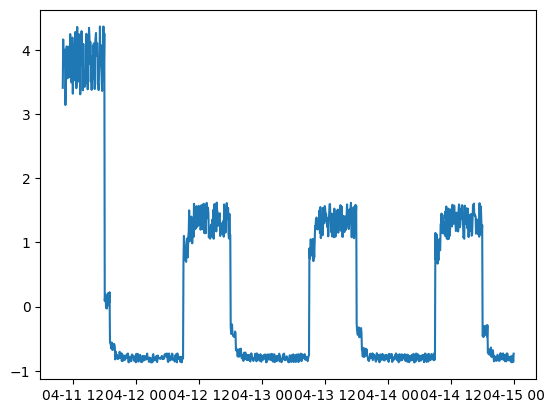

In [105]:
plt.plot(df_test_value[3000:4032])

In [91]:
partitions = ['test_2']
data_dic = {'test_2': x_test}
batch_size = 1
shuffle = False
TS_datasets = {x: TS_dataLoader(data_dic[x]) for x in partitions}
dataloaders = {x: torch.utils.data.DataLoader(TS_datasets[x], batch_size=batch_size,\
                                              shuffle=shuffle) for x in partitions}
dataset_sizes = {x: len(TS_datasets[x]) for x in partitions}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'test_2': 3745}

In [94]:
model.eval()
loss_prediction = []
predictions_test = []
ts_real = []
for k, batch_data in enumerate(dataloaders['test_2']):
    ts_patch  = batch_data
    ts_patch = ts_patch.float()
    ts_patch = ts_patch.permute((0,2,1))
    output_ts = model(ts_patch)
#     print(output_ts.shape)
    predictions_test.append(output_ts[0].squeeze().detach().numpy())
    ts_real.append(ts_patch[0].squeeze().detach().numpy())
    loss_prediction.append(np.mean(np.abs(output_ts.detach().numpy() - ts_patch.numpy()), axis=1))

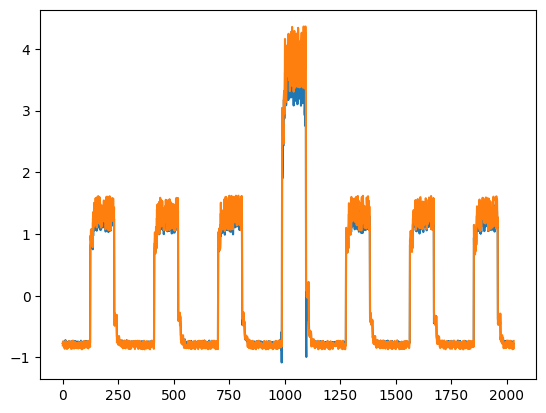

In [129]:
test_anomaly = df_test_value[2000:4032]
plt.plot(model(torch.from_numpy(np.array(test_anomaly)).unsqueeze(0).permute((0,2,1)).float()).squeeze().detach().numpy())
plt.plot(np.array(test_anomaly))
# model()

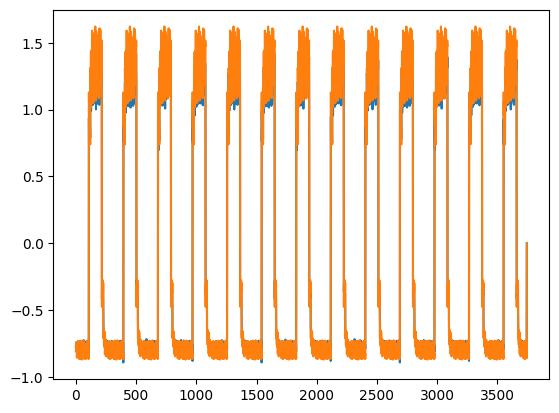

In [95]:
plt.plot(create_ts_from_seq(np.expand_dims(np.array(predictions_test),axis=2)))
plt.plot(create_ts_from_seq(np.expand_dims(np.array(ts_real),axis=2)))
plt.show()